In [ ]:
# Access files from your Google Drive
from google.colab import drive
drive.mount('/content/gdrive')

In [1]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [2]:
!pip install -U tensorflow-addons

# Libraries and Configurations

In [3]:
import pandas as pd
import numpy as np
import tensorflow as tf
import tensorflow_addons as tfa
import glob, warnings
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPool2D, BatchNormalization,Input,MaxPooling2D,GlobalMaxPooling2D,concatenate
warnings.filterwarnings('ignore')
print('TensorFlow Version ' + tf.__version__)
import cv2 
from tensorflow.keras.optimizers import Adam

C:\ProgramData\Anaconda3\envs\ev_2\lib\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
C:\ProgramData\Anaconda3\envs\ev_2\lib\site-packages\tensorflow_addons\utils\ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.10.0 and strictly below 2.13.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.6.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you w

TensorFlow Version 2.6.0


In [4]:
image_size = 224
batch_size = 8
EPOCHS = 50

train_data_dir = 'C:/Users/yared/Desktop/Olyad/HASHIM/WITH NEW AMD DATA/no healthy data(good)/TRAIN'
test_data_dir = 'C:/Users/yared/Desktop/Olyad/HASHIM/WITH NEW AMD DATA/no healthy data(good)/TEST'


# Data Generator

In [5]:
datagen = ImageDataGenerator(
    #horizontal_flip=True,
    #vertical_flip=True,
    #rotation_range=30,
  #  width_shift_range=0.1,
 #   height_shift_range=0.1,
  #  zoom_range=.1,
    rescale=1/255,
  #  fill_mode='nearest',
  #  shear_range=0.1,
  #  brightness_range=[0.5, 1.5],
    validation_split=0.2)

In [6]:
train_generator = datagen.flow_from_directory(
        train_data_dir,
        target_size = (image_size, image_size),
        batch_size=batch_size,
        class_mode='categorical',  
        subset='training')
 

validation_generator = datagen.flow_from_directory(
        train_data_dir,
        target_size = (image_size, image_size),
        batch_size=batch_size,
        class_mode='categorical', 
        subset='validation',
        shuffle=False)

test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
        test_data_dir,
        target_size=(image_size,image_size),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False)#shuffle should be False in validation

Found 7354 images belonging to 6 classes.
Found 1835 images belonging to 6 classes.
Found 1153 images belonging to 6 classes.


## 1.  Model Building

In [9]:
!pip install --quiet vit-keras

from vit_keras import vit

In [10]:
import tensorflow.keras as keras

keras.utils.get_custom_objects().clear()


In [11]:
from tensorflow.keras.layers import Flatten, BatchNormalization, Activation
from tensorflow.keras.regularizers import l2

import sys
sys.path.append('C:/Users/yared/Desktop/Olyad/HASHIM/transformers')
from cvit.vitcustom_parallel import *

# Available models: vit_custom_b16, vit_custom_b32, vit_custom_l16, vit_custom_l32

model = vit_custom_b16(
    image_size=224,
    activation='softmax',
    pretrained=True,
    include_top=False,
    pretrained_top=False,
    classes = 6,
    weights = 'imagenet21k')       # +imagenet2012

x = model.output
# to add custom MLP Head 
# Flatten layer
#x = Flatten()(x)
# Batch normalization layer
#x = BatchNormalization()(x)
# Dense layer with GELU activation and L2 regularization
#x = Dense(128, kernel_regularizer=l2(0.001))(x)
#x = Activation('gelu')(x)
# Batch normalization layer
#x = BatchNormalization()(x)
# Batch normalization layer
#x = BatchNormalization()(x)

model_out = Dense(6, activation='softmax')(x)
model = Model(inputs=model.input, outputs=model_out)

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
embedding (Conv2D)              (None, 14, 14, 768)  590592      input_1[0][0]                    
__________________________________________________________________________________________________
par_cnn_0 (Conv2D)              (None, 222, 222, 16) 448         input_1[0][0]                    
__________________________________________________________________________________________________
patch_embed_to_1D (Reshape)     (None, 196, 768)     0           embedding[0][0]                  
______________________________________________________________________________________________

In [ ]:
# pretrained_vit = vit.vit_b16(
#         weights='imagenet21k+imagenet2012',  # remove imagenet  +imagenet2012 # olyad check with single or dfferent version of imagenet (either Imagenet21k or Imagene1k only or combination of both )
#         image_size = image_size,
#         activation = 'softmax',
#         pretrained = True,
#         include_top = False,
#         pretrained_top = False,
#         classes = 2)


# #Adding custom Layers 
# x = pretrained_vit.output

# model_out = Dense(2, activation='softmax', name="predictions_head")(x)
# model = Model(inputs=pretrained_vit.input, outputs=model_out)


In [12]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
embedding (Conv2D)              (None, 14, 14, 768)  590592      input_1[0][0]                    
__________________________________________________________________________________________________
par_cnn_0 (Conv2D)              (None, 222, 222, 16) 448         input_1[0][0]                    
__________________________________________________________________________________________________
patch_embed_to_1D (Reshape)     (None, 196, 768)     0           embedding[0][0]                  
______________________________________________________________________________________________

In [13]:
# Let's print our layers 
for (i,layer) in enumerate(model.layers):
    print(str(i) + " "+ layer.__class__.__name__, layer.trainable)

0 InputLayer True
1 Conv2D True
2 Conv2D True
3 Reshape True
4 Conv2D True
5 ClassToken True
6 Conv2D True
7 AddPositionEmbs True
8 Reshape True
9 TransformerBlock True
10 MaxPooling1D True
11 Concatenate True
12 TransformerBlock True
13 Concatenate True
14 TransformerBlock True
15 Concatenate True
16 TransformerBlock True
17 Concatenate True
18 TransformerBlock True
19 Concatenate True
20 TransformerBlock True
21 Concatenate True
22 TransformerBlock True
23 Concatenate True
24 TransformerBlock True
25 Concatenate True
26 TransformerBlock True
27 Concatenate True
28 TransformerBlock True
29 Concatenate True
30 TransformerBlock True
31 Concatenate True
32 TransformerBlock True
33 Concatenate True
34 LayerNormalization True
35 Lambda True
36 Dense True
37 Dense True


# Training the Model

In [14]:
  def custom_loss(y_true, y_pred):
    return tf.keras.losses.categorical_crossentropy(y_true, y_pred, label_smoothing=0.1)
  model.compile(optimizer=Adam(0.0001), loss=custom_loss, metrics=['accuracy'])




STEP_SIZE_TRAIN = train_generator.n // train_generator.batch_size
STEP_SIZE_VALID = validation_generator.n // validation_generator.batch_size

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_accuracy',
                                                 factor = 0.2,
                                                 patience = 2,    # 3 or 4 
                                                 verbose = 1,
                                                 min_delta = 1e-4,
                                                 min_lr = 1e-6,
                                                 mode = 'max')

earlystopping = tf.keras.callbacks.EarlyStopping(monitor = 'val_accuracy',
                                                 min_delta = 1e-4,
                                                 patience = 20,
                                                 mode = 'max',
                                                 restore_best_weights = True,
                                                 verbose = 1)

checkpointer = tf.keras.callbacks.ModelCheckpoint(filepath = 'C:/Users/yared/Desktop/Olyad/HASHIM/WITH NEW AMD DATA/no healthy data(good)/CUSTOMB16model.h5',
                                                  monitor = 'val_accuracy', 
                                                  verbose = 1, 
                                                  save_best_only = True,
                                                  save_weights_only = False,
                                                  mode = 'max')

callbacks = [earlystopping, reduce_lr, checkpointer]

history_vit= model.fit(train_generator,
          steps_per_epoch = STEP_SIZE_TRAIN,
          validation_data = validation_generator,
          validation_steps = STEP_SIZE_VALID,
          epochs = EPOCHS,
          callbacks = callbacks)



Epoch 1/50
919/919 [==============================] - 1646s 2s/step - loss: 0.5626 - accuracy: 0.9386 - val_loss: 0.5069 - val_accuracy: 0.9662

Epoch 00001: val_accuracy improved from -inf to 0.96616, saving model to C:/Users/yared/Desktop/Olyad/HASHIM/WITH NEW AMD DATA/no healthy data(good)\CUSTOMB16model.h5
Epoch 2/50
919/919 [==============================] - 1510s 2s/step - loss: 0.4611 - accuracy: 0.9842 - val_loss: 0.4979 - val_accuracy: 0.9694

Epoch 00002: val_accuracy improved from 0.96616 to 0.96943, saving model to C:/Users/yared/Desktop/Olyad/HASHIM/WITH NEW AMD DATA/no healthy data(good)\CUSTOMB16model.h5
Epoch 3/50
919/919 [==============================] - 1521s 2s/step - loss: 0.4592 - accuracy: 0.9842 - val_loss: 0.4756 - val_accuracy: 0.9809

Epoch 00003: val_accuracy improved from 0.96943 to 0.98090, saving model to C:/Users/yared/Desktop/Olyad/HASHIM/WITH NEW AMD DATA/no healthy data(good)\CUSTOMB16model.h5
Epoch 4/50
919/919 [==============================] - 1515

# Model Results

144/144 [==============================] - 72s 474ms/step
Confusion Matrix
[[139   0   0   1   0   0]
 [  2 201  12   1   0   0]
 [ 13   4 155  19   0   0]
 [  0   8   0 232   0   0]
 [  0   0   0   0 184   0]
 [  0   0   0   0   0 182]]
Classification Report
              precision    recall  f1-score   support

         AMD       0.90      0.99      0.95       140
    CATARACT       0.94      0.93      0.94       216
          DR       0.93      0.81      0.87       191
    GLAUCOMA       0.92      0.97      0.94       240
     HEALTHY       1.00      1.00      1.00       184
       OTHER       1.00      1.00      1.00       182

    accuracy                           0.95      1153
   macro avg       0.95      0.95      0.95      1153
weighted avg       0.95      0.95      0.95      1153



<Figure size 800x800 with 0 Axes>

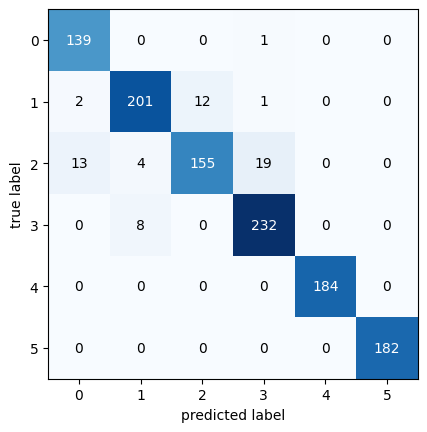

In [15]:
import matplotlib.pyplot as plt
import sklearn
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import numpy as np


class_labels = test_generator.class_indices
class_labels = {v: k for k, v in class_labels.items()}
classes = list(class_labels.values())

#Confusion Matrix and Classification Report
y_pred=model.predict(test_generator,steps=test_generator.n/batch_size,verbose=1)
y_pred = np.argmax(y_pred, axis=1) 
y_true = test_generator.classes

print('Confusion Matrix')
print(confusion_matrix(y_true, y_pred))


print('Classification Report')
target_names = list(class_labels.values())
print(classification_report(y_true, y_pred, target_names=target_names))

plt.figure(figsize=(8,8))
cnf_matrix = confusion_matrix(test_generator.classes, y_pred)

from mlxtend.plotting import plot_confusion_matrix
fig, ax = plot_confusion_matrix(cnf_matrix) 
plt.show()


<Figure size 640x480 with 0 Axes>

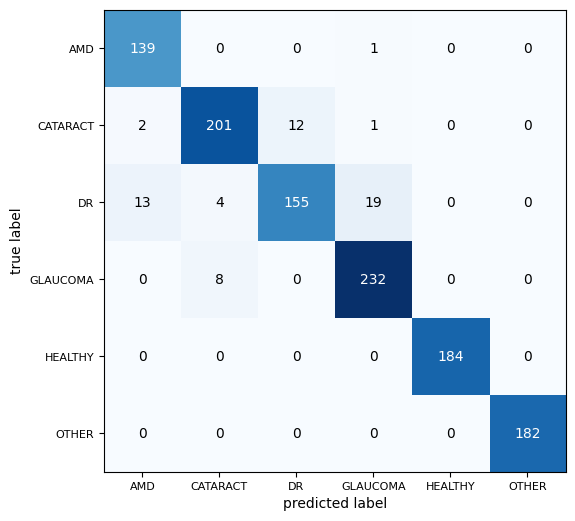

In [37]:
# Get the confusion matrix
cm  = confusion_matrix(y_true, y_pred)
plt.figure()
plot_confusion_matrix(cm,figsize=(6,6), hide_ticks=True,cmap=plt.cm.Blues)
plt.xticks(range(6), ['AMD','CATARACT','DR','GLAUCOMA','HEALTHY','OTHER'], fontsize=8)
plt.yticks(range(6), ['AMD','CATARACT','DR','GLAUCOMA','HEALTHY','OTHER'], fontsize=8)
plt.show()

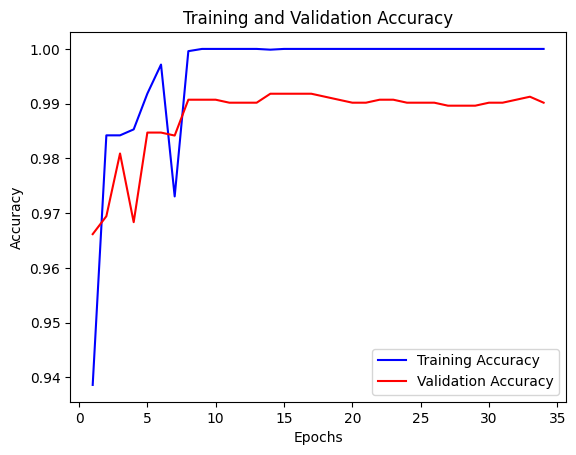

In [19]:
import matplotlib.pyplot as plt

# Get the training accuracy and validation accuracy from the history object
train_accuracy = history_vit.history['accuracy']
val_accuracy = history_vit.history['val_accuracy']

# Create a list of epochs
epochs = range(1, len(train_accuracy) + 1)

# Plot the training accuracy and validation accuracy
plt.plot(epochs, train_accuracy, 'b', label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'r', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


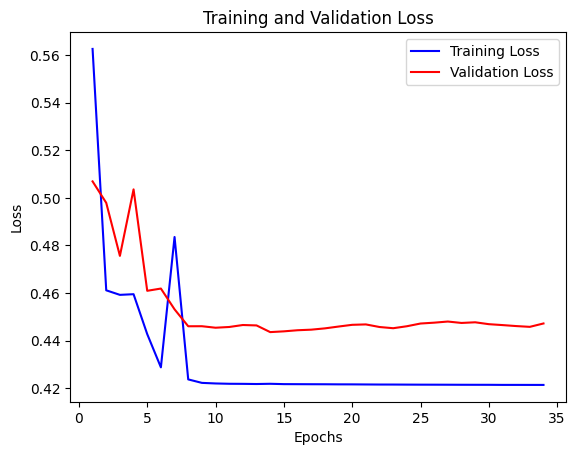

In [20]:
# Get the training loss and validation loss from the history object
train_loss = history_vit.history['loss']
val_loss = history_vit.history['val_loss']

# Create a new figure and plot the training loss and validation loss
plt.figure()
plt.plot(epochs, train_loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


below code calculates precision and recall for each class 

In [21]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

# Assume y_true and y_pred are arrays with true and predicted labels respectively

cm = confusion_matrix(y_true, y_pred)
num_classes = cm.shape[0]

accuracy = accuracy_score(y_true, y_pred)

precision_list = []
recall_list = []
f1_list = []

for i in range(num_classes):
    tp = cm[i,i]
    fp = np.sum(cm[:,i]) - tp
    fn = np.sum(cm[i,:]) - tp
    
    precision = precision_score(y_true, y_pred, labels=[i], average='micro')
    recall = recall_score(y_true, y_pred, labels=[i], average='micro')
    f1 = f1_score(y_true, y_pred, labels=[i], average='micro')
    
    precision_list.append(precision)
    recall_list.append(recall)
    f1_list.append(f1)
    
    print("Class {} - Precision: {:.2f}, Recall: {:.2f}, F1-score: {:.2f}".format(i, precision, recall, f1))

# Calculate macro-average of precision, recall, and f1-score
macro_precision = sum(precision_list) / num_classes
macro_recall = sum(recall_list) / num_classes
macro_f1 = sum(f1_list) / num_classes

print("Macro-averaged Precision: {:.2f}".format(macro_precision))
print("Macro-averaged Recall: {:.2f}".format(macro_recall))
print("Macro-averaged F1-score: {:.2f}".format(macro_f1))
print("Accuracy is {:.2f}".format(accuracy))


Class 0 - Precision: 0.90, Recall: 0.99, F1-score: 0.95
Class 1 - Precision: 0.94, Recall: 0.93, F1-score: 0.94
Class 2 - Precision: 0.93, Recall: 0.81, F1-score: 0.87
Class 3 - Precision: 0.92, Recall: 0.97, F1-score: 0.94
Class 4 - Precision: 1.00, Recall: 1.00, F1-score: 1.00
Class 5 - Precision: 1.00, Recall: 1.00, F1-score: 1.00
Macro-averaged Precision: 0.95
Macro-averaged Recall: 0.95
Macro-averaged F1-score: 0.95
Accuracy is 0.95


In [ ]:
# Calculate Precision and Recall
tn, fp, fn, tp = cm.ravel()

accuracy = accuracy_score(y_true, y_pred)
precision = tp/(tp+fp)
recall = tp/(tp+fn)
specificity = tn/(tn+fp)
f1 = 2*precision*recall/(precision+recall)

print("Accuracy is {}".format(accuracy))
print("Recall/Sensitivity of the model is {}".format(recall))
print("Precision of the model is {}".format(precision))
print("F1-score of the model is {}".format(f1))
print("Specificity of the model is {}".format(specificity))


In [ ]:
# BELOW CODE IS FOR ROC-AUC CURVE FOR MULTI CLASS CLASSIFICATION

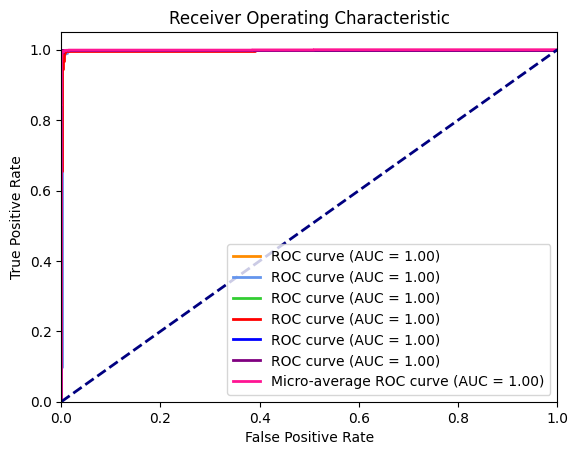

In [23]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# Assuming you have the predicted probabilities or scores for each class
predicted_scores = model.predict(validation_generator)
true_labels = validation_generator.labels

# Binarize the true labels
num_classes = len(np.unique(true_labels))
binarized_labels = label_binarize(true_labels, classes=np.arange(num_classes))

# Compute the ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(binarized_labels[:, i], predicted_scores[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and AUC
fpr_micro, tpr_micro, _ = roc_curve(binarized_labels.ravel(), predicted_scores.ravel())
roc_auc_micro = auc(fpr_micro, tpr_micro)

# Plot the ROC curves for each class
plt.figure()
colors = ['darkorange', 'cornflowerblue', 'limegreen', 'red', 'blue', 'purple']  # Adjust the colors as needed
for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], color=colors[i], lw=2,
             label='ROC curve (AUC = %0.2f)' % roc_auc[i])

# Plot the micro-average ROC curve
plt.plot(fpr_micro, tpr_micro, color='deeppink', lw=2,
         label='Micro-average ROC curve (AUC = %0.2f)' % roc_auc_micro)

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


In [ ]:
# ROC FOR MULTI CLASS 

In [24]:
from sklearn.metrics import roc_auc_score

# Assuming you have the predicted scores and true labels
predicted_scores = model.predict(validation_generator)
true_labels = validation_generator.labels

# Calculate the ROC AUC score
roc_auc = roc_auc_score(true_labels, predicted_scores, multi_class='ovr')

print("ROC AUC score:", roc_auc)

ROC AUC score: 0.9994438927747265


144/144 [==============================] - 54s 372ms/step


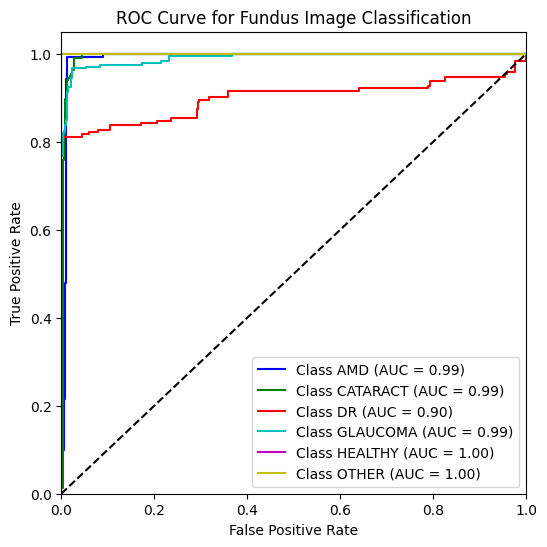

In [41]:
# Calculate the number of steps needed to cover all samples in the test dataset
num_steps = test_generator.n // test_generator.batch_size

# Predict probabilities for all samples using the test generator
y_pred = model.predict(test_generator, steps=num_steps, verbose=1)

# Flatten the true labels to match the shape of y_pred
y_true = np.concatenate([test_generator[i][1] for i in range(num_steps)])

# Calculate ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

n_classes = len(classes)

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve((y_true[:, i] == 1).astype(int), y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves for each class
plt.figure(figsize=(6, 6))
colors = ['b', 'g', 'r', 'c', 'm', 'y']  # Customize colors if needed

for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], color=colors[i], label=f'Class {classes[i]} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line for random classifier
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Fundus Image Classification')
plt.legend(loc="lower right")
plt.show()


In [ ]:
# ROC AUC score for multi class 

In [42]:
from sklearn.metrics import roc_auc_score

# Assuming you have the predicted scores and true labels
predicted_scores = model.predict(validation_generator)
true_labels = validation_generator.labels

# Calculate the ROC AUC score
roc_auc = roc_auc_score(true_labels, predicted_scores, multi_class='ovr')

print("ROC AUC score:", roc_auc)


ROC AUC score: 0.9994438927747265


In [ ]:
# ROC for binary class 

In [ ]:
import sklearn.metrics as metrics
fpr, tpr, threshold = metrics.roc_curve(y_true, y_pred)
roc_auc = metrics.auc(fpr, tpr)

# method I: plt
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [ ]:
import numpy as np
from sklearn.metrics import roc_auc_score
roc_auc_score(y_true, y_pred)

In [1]:
import argparse
import csv
import os
import tqdm
import pdb
import shutil
import time
import torch
import numpy as np
import torchvision
import torch.nn as nn
import os.path as osp
import torch.optim as optim
from torchvision import datasets, models
from functools import partial
import torchvision.models as models
import torch.optim as optim
from torch.autograd import Variable
from torch.backends import cudnn
from torch.optim.lr_scheduler import ReduceLROnPlateau

from model.baseline import Pre_ResNet18Model1
from model.modified_model import Freezing_layer_Resnet18WithCCSAM1
from model.modified_model import resnet18_ccsam

from torch.utils.tensorboard import SummaryWriter
from datetime import datetime
import matplotlib.pyplot as plt

C:\Users\HIREE\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\HIREE\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [48]:
#model=Pre_ResNet18Model1(num_classes=5)
#model=my_InceptionV3(num_classes=5)
#model=resnet18_ccsam(num_classes=5)
#model=ccsam_inception_v3(num_classes=5)
model = Freezing_layer_Resnet18WithCCSAM1(num_classes=5)
#model = model.cuda()

print(model)

C:\Users\HIREE\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\HIREE\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Freezing_layer_Resnet18WithCCSAM(
  (model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (CCSAM): CCSAM(
          (channel_attention): ChannelAttention(
            (avg_pool): AdaptiveAvgPool2d(output_size=1)
            (max_pool): AdaptiveMaxPool2d(output_si

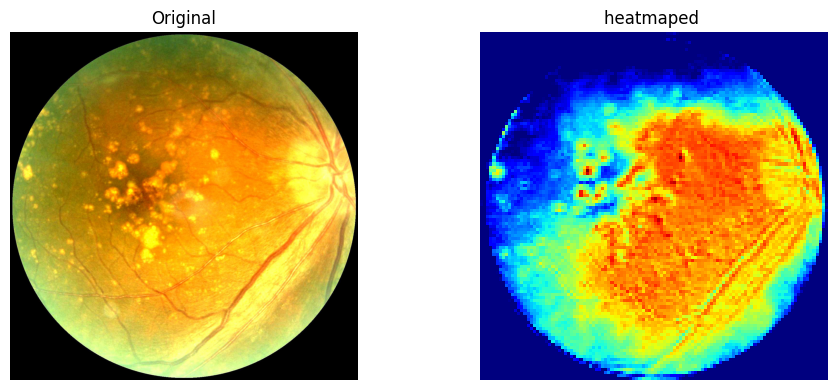

In [14]:
import torch
import torch.nn as nn
import torchvision.models as models
from torchvision import transforms
import cv2
from torchvision.models import ResNet
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
# Load the pre-trained RESNET18 model with CBAM attention mechanism
model=resnet18_ccsam(num_classes=5)

# Remove the last fully connected layer
#model.fc = torch.nn.Identity()
#model.fc2 = torch.nn.Identity()
#model = Freezing_layer_Resnet18WithCCSAM1(num_classes=5)

# Load the ResNet18 model
#model = models.resnet18(pretrained=True)
#model.eval()
# Load the pre-trained ResNet50 model
#model=Pre_ResNet18Model1(num_classes=5)
model.eval()

# Define the preprocessing transformations
preprocess = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Load and preprocess the image
image_path = "E:/jupyter notebook/last_code_model/olii/AMD.jpg"
#image_path = "E:/jupyter notebook/last_code_model/olii/CATARACT.jpg"
#image_path = "E:/jupyter notebook/last_code_model/olii/DR.jpg"
#image_path = "E:/jupyter notebook/last_code_model/olii/GLAUCOMA.jpg"
#image_path = "E:/jupyter notebook/last_code_model/olii/OTHER.jpg"
image = Image.open(image_path).convert('RGB')
# Preprocess the image

input_tensor = preprocess(image).unsqueeze(0)

# Forward pass through the model
output = model(input_tensor)
pred_label = torch.argmax(output, dim=1).item()

# Get the gradients with respect to the input tensor
model.zero_grad()
output[:, pred_label].backward()

# Get the gradients from the model's first convolutional layer
gradients = model.conv1.weight.grad

# Average the gradients across the RGB channels
pooled_gradients = torch.mean(gradients, dim=[2, 3])

# Get the feature maps from the last convolutional layer
features = model.conv1(input_tensor)


# Multiply the feature maps by the corresponding gradients
for i in range(features.size(0)):
    features[:, i, :, :] *= pooled_gradients[0, i]

# Sum the feature maps along the channels dimension
heatmap = torch.sum(features, dim=1).squeeze()

# Normalize the heat map values
heatmap = nn.functional.relu(heatmap)
heatmap /= torch.max(heatmap)

# Convert the heat map to a numpy array
heatmap = heatmap.detach().numpy()

# Visualize the heat map
#plt.imshow('Original Image', image)
#plt.imshow(heatmap, cmap='jet')
#plt.axis('off')
#plt.show()

# Apply the attention map to the original image
#heatmap = cv2.applyColorMap(attention_map, cv2.COLORMAP_JET)
# Superimpose the heat map on the original image

# Display the original image, attention map, and superimposed image
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
ax[0].imshow(image)
ax[0].set_title('Original')
ax[0].axis('off')

ax[1].imshow(heatmap, cmap='jet')
ax[1].set_title('heatmaped ')
ax[1].axis('off')


plt.tight_layout()
plt.show()



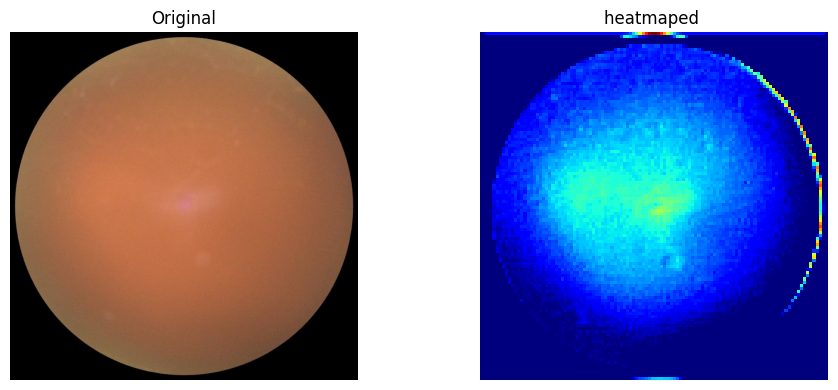

In [15]:
import torch
import torch.nn as nn
import torchvision.models as models
from torchvision import transforms
import cv2
from torchvision.models import ResNet
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
# Load the pre-trained RESNET18 model with CBAM attention mechanism
model=resnet18_ccsam(num_classes=5)

# Remove the last fully connected layer
#model.fc = torch.nn.Identity()
#model.fc2 = torch.nn.Identity()
#model = Freezing_layer_Resnet18WithCCSAM1(num_classes=5)

# Load the ResNet18 model
#model = models.resnet18(pretrained=True)
#model.eval()
# Load the pre-trained ResNet50 model
#model=Pre_ResNet18Model1(num_classes=5)
model.eval()

# Define the preprocessing transformations
preprocess = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Load and preprocess the image
#image_path = "E:/jupyter notebook/last_code_model/olii/AMD.jpg"
image_path = "E:/jupyter notebook/last_code_model/olii/CATARACT.jpg"
#image_path = "E:/jupyter notebook/last_code_model/olii/DR.jpg"
#image_path = "E:/jupyter notebook/last_code_model/olii/GLAUCOMA.jpg"
#image_path = "E:/jupyter notebook/last_code_model/olii/OTHER.jpg"
image = Image.open(image_path).convert('RGB')
# Preprocess the image

input_tensor = preprocess(image).unsqueeze(0)

# Forward pass through the model
output = model(input_tensor)
pred_label = torch.argmax(output, dim=1).item()

# Get the gradients with respect to the input tensor
model.zero_grad()
output[:, pred_label].backward()

# Get the gradients from the model's first convolutional layer
gradients = model.conv1.weight.grad

# Average the gradients across the RGB channels
pooled_gradients = torch.mean(gradients, dim=[2, 3])

# Get the feature maps from the last convolutional layer
features = model.conv1(input_tensor)


# Multiply the feature maps by the corresponding gradients
for i in range(features.size(0)):
    features[:, i, :, :] *= pooled_gradients[0, i]

# Sum the feature maps along the channels dimension
heatmap = torch.sum(features, dim=1).squeeze()

# Normalize the heat map values
heatmap = nn.functional.relu(heatmap)
heatmap /= torch.max(heatmap)

# Convert the heat map to a numpy array
heatmap = heatmap.detach().numpy()

# Visualize the heat map
#plt.imshow('Original Image', image)
#plt.imshow(heatmap, cmap='jet')
#plt.axis('off')
#plt.show()

# Apply the attention map to the original image
#heatmap = cv2.applyColorMap(attention_map, cv2.COLORMAP_JET)
# Superimpose the heat map on the original image

# Display the original image, attention map, and superimposed image
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
ax[0].imshow(image)
ax[0].set_title('Original')
ax[0].axis('off')

ax[1].imshow(heatmap, cmap='jet')
ax[1].set_title('heatmaped ')
ax[1].axis('off')


plt.tight_layout()
plt.show()



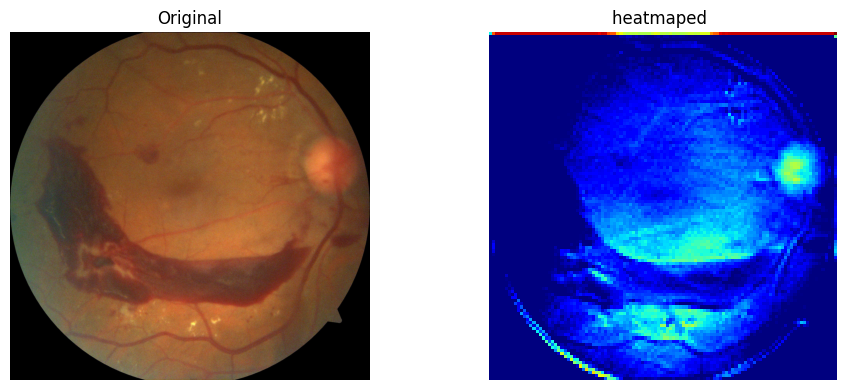

In [73]:
import torch
import torch.nn as nn
import torchvision.models as models
from torchvision import transforms
import cv2
from torchvision.models import ResNet
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
# Load the pre-trained RESNET18 model with CBAM attention mechanism
model=resnet18_ccsam(num_classes=5)

# Remove the last fully connected layer
#model.fc = torch.nn.Identity()
#model.fc2 = torch.nn.Identity()
#model = Freezing_layer_Resnet18WithCCSAM1(num_classes=5)

# Load the ResNet18 model
#model = models.resnet18(pretrained=True)
#model.eval()
# Load the pre-trained ResNet50 model
#model=Pre_ResNet18Model1(num_classes=5)
model.eval()

# Define the preprocessing transformations
preprocess = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Load and preprocess the image
#image_path = "E:/jupyter notebook/last_code_model/olii/AMD.jpg"
#image_path = "E:/jupyter notebook/last_code_model/olii/CATARACT.jpg"
image_path = "E:/jupyter notebook/last_code_model/olii/DR.jpg"
#image_path = "E:/jupyter notebook/last_code_model/olii/GLAUCOMA.jpg"
#image_path = "E:/jupyter notebook/last_code_model/olii/OTHER.jpg"
image = Image.open(image_path).convert('RGB')
# Preprocess the image

input_tensor = preprocess(image).unsqueeze(0)

# Forward pass through the model
output = model(input_tensor)
pred_label = torch.argmax(output, dim=1).item()

# Get the gradients with respect to the input tensor
model.zero_grad()
output[:, pred_label].backward()

# Get the gradients from the model's first convolutional layer
gradients = model.conv1.weight.grad

# Average the gradients across the RGB channels
pooled_gradients = torch.mean(gradients, dim=[2, 3])

# Get the feature maps from the last convolutional layer
features = model.conv1(input_tensor)


# Multiply the feature maps by the corresponding gradients
for i in range(features.size(0)):
    features[:, i, :, :] *= pooled_gradients[0, i]

# Sum the feature maps along the channels dimension
heatmap = torch.sum(features, dim=1).squeeze()

# Normalize the heat map values
heatmap = nn.functional.relu(heatmap)
heatmap /= torch.max(heatmap)

# Convert the heat map to a numpy array
heatmap = heatmap.detach().numpy()

# Visualize the heat map
#plt.imshow('Original Image', image)
#plt.imshow(heatmap, cmap='jet')
#plt.axis('off')
#plt.show()

# Apply the attention map to the original image
#heatmap = cv2.applyColorMap(attention_map, cv2.COLORMAP_JET)
# Superimpose the heat map on the original image

# Display the original image, attention map, and superimposed image
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
ax[0].imshow(image)
ax[0].set_title('Original')
ax[0].axis('off')

ax[1].imshow(heatmap, cmap='jet')
ax[1].set_title('heatmaped ')
ax[1].axis('off')


plt.tight_layout()
plt.show()



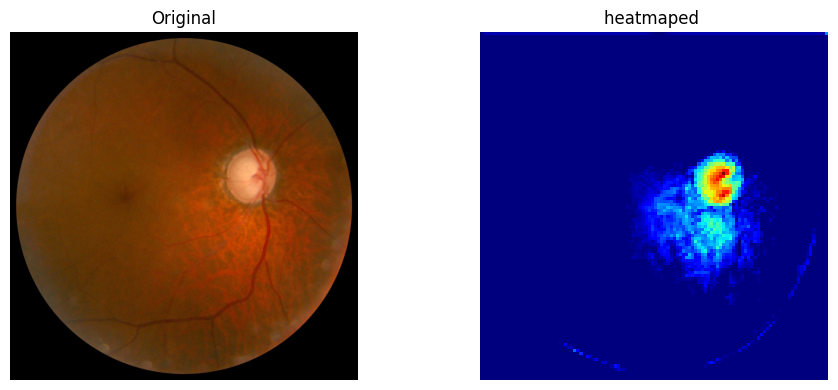

In [39]:
import torch
import torch.nn as nn
import torchvision.models as models
from torchvision import transforms
import cv2
from torchvision.models import ResNet
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
# Load the pre-trained RESNET18 model with CBAM attention mechanism
model=resnet18_ccsam(num_classes=5)

# Remove the last fully connected layer
#model.fc = torch.nn.Identity()
#model.fc2 = torch.nn.Identity()
#model = Freezing_layer_Resnet18WithCCSAM1(num_classes=5)

# Load the ResNet18 model
#model = models.resnet18(pretrained=True)
#model.eval()
# Load the pre-trained ResNet50 model
#model=Pre_ResNet18Model1(num_classes=5)
model.eval()

# Define the preprocessing transformations
preprocess = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Load and preprocess the image
#image_path = "E:/jupyter notebook/last_code_model/olii/AMD.jpg"
#image_path = "E:/jupyter notebook/last_code_model/olii/CATARACT.jpg"
#image_path = "E:/jupyter notebook/last_code_model/olii/DR.jpg"
image_path = "E:/jupyter notebook/last_code_model/olii/GLAUCOMA.jpg"
#image_path = "E:/jupyter notebook/last_code_model/olii/OTHER.jpg"
image = Image.open(image_path).convert('RGB')
# Preprocess the image

input_tensor = preprocess(image).unsqueeze(0)

# Forward pass through the model
output = model(input_tensor)
pred_label = torch.argmax(output, dim=1).item()

# Get the gradients with respect to the input tensor
model.zero_grad()
output[:, pred_label].backward()

# Get the gradients from the model's first convolutional layer
gradients = model.conv1.weight.grad

# Average the gradients across the RGB channels
pooled_gradients = torch.mean(gradients, dim=[2, 3])

# Get the feature maps from the last convolutional layer
features = model.conv1(input_tensor)


# Multiply the feature maps by the corresponding gradients
for i in range(features.size(0)):
    features[:, i, :, :] *= pooled_gradients[0, i]

# Sum the feature maps along the channels dimension
heatmap = torch.sum(features, dim=1).squeeze()

# Normalize the heat map values
heatmap = nn.functional.relu(heatmap)
heatmap /= torch.max(heatmap)

# Convert the heat map to a numpy array
heatmap = heatmap.detach().numpy()

# Visualize the heat map
#plt.imshow('Original Image', image)
#plt.imshow(heatmap, cmap='jet')
#plt.axis('off')
#plt.show()

# Apply the attention map to the original image
#heatmap = cv2.applyColorMap(attention_map, cv2.COLORMAP_JET)
# Superimpose the heat map on the original image

# Display the original image, attention map, and superimposed image
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
ax[0].imshow(image)
ax[0].set_title('Original')
ax[0].axis('off')

ax[1].imshow(heatmap, cmap='jet')
ax[1].set_title('heatmaped ')
ax[1].axis('off')


plt.tight_layout()
plt.show()



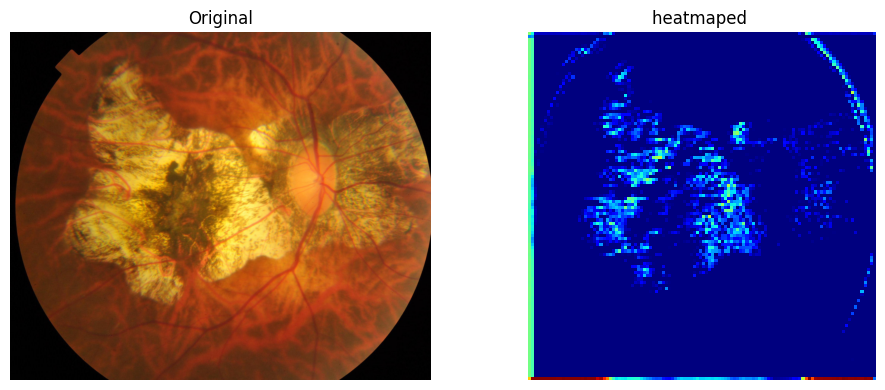

In [47]:
import torch
import torch.nn as nn
import torchvision.models as models
from torchvision import transforms
import cv2
from torchvision.models import ResNet
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
# Load the pre-trained RESNET18 model with CBAM attention mechanism
model=resnet18_ccsam(num_classes=5)

# Remove the last fully connected layer
#model.fc = torch.nn.Identity()
#model.fc2 = torch.nn.Identity()
#model = Freezing_layer_Resnet18WithCCSAM1(num_classes=5)

# Load the ResNet18 model
#model = models.resnet18(pretrained=True)
#model.eval()
# Load the pre-trained ResNet50 model
#model=Pre_ResNet18Model1(num_classes=5)
model.eval()

# Define the preprocessing transformations
preprocess = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Load and preprocess the image
#image_path = "E:/jupyter notebook/last_code_model/olii/AMD.jpg"
#image_path = "E:/jupyter notebook/last_code_model/olii/CATARACT.jpg"
#image_path = "E:/jupyter notebook/last_code_model/olii/DR.jpg"
#image_path = "E:/jupyter notebook/last_code_model/olii/GLAUCOMA.jpg"
image_path = "E:/jupyter notebook/last_code_model/olii/OTHER.jpg"
image = Image.open(image_path).convert('RGB')
# Preprocess the image

input_tensor = preprocess(image).unsqueeze(0)

# Forward pass through the model
output = model(input_tensor)
pred_label = torch.argmax(output, dim=1).item()

# Get the gradients with respect to the input tensor
model.zero_grad()
output[:, pred_label].backward()

# Get the gradients from the model's first convolutional layer
gradients = model.conv1.weight.grad

# Average the gradients across the RGB channels
pooled_gradients = torch.mean(gradients, dim=[2, 3])

# Get the feature maps from the last convolutional layer
features = model.conv1(input_tensor)


# Multiply the feature maps by the corresponding gradients
for i in range(features.size(0)):
    features[:, i, :, :] *= pooled_gradients[0, i]

# Sum the feature maps along the channels dimension
heatmap = torch.sum(features, dim=1).squeeze()

# Normalize the heat map values
heatmap = nn.functional.relu(heatmap)
heatmap /= torch.max(heatmap)

# Convert the heat map to a numpy array
heatmap = heatmap.detach().numpy()

# Visualize the heat map
#plt.imshow('Original Image', image)
#plt.imshow(heatmap, cmap='jet')
#plt.axis('off')
#plt.show()

# Apply the attention map to the original image
#heatmap = cv2.applyColorMap(attention_map, cv2.COLORMAP_JET)
# Superimpose the heat map on the original image

# Display the original image, attention map, and superimposed image
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
ax[0].imshow(image)
ax[0].set_title('Original')
ax[0].axis('off')

ax[1].imshow(heatmap, cmap='jet')
ax[1].set_title('heatmaped ')
ax[1].axis('off')


plt.tight_layout()
plt.show()



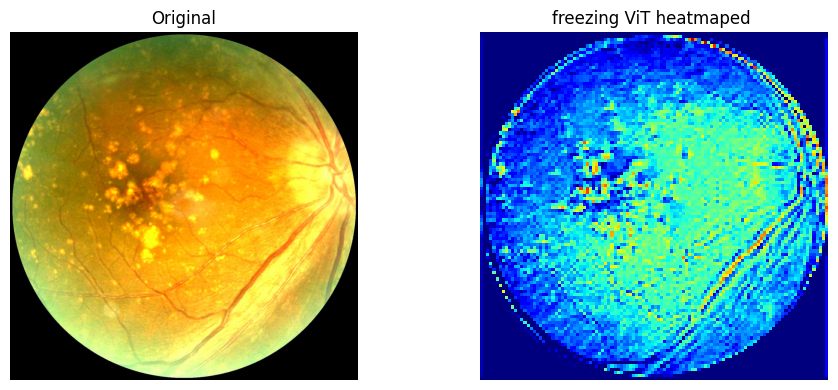

In [49]:
import torch
import torch.nn as nn
import torchvision.models as models
from torchvision import transforms
import cv2
from torchvision.models import ResNet
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
# Load the pre-trained RESNET18 model with CBAM attention mechanism
#model=resnet18_ccsam(num_classes=5)

# Remove the last fully connected layer
#model.fc = torch.nn.Identity()
#model.fc2 = torch.nn.Identity()
model = Freezing_layer_Resnet18WithCCSAM1(num_classes=5)

# Load the ResNet18 model
#model = models.resnet18(pretrained=True)
#model.eval()
# Load the pre-trained ResNet50 model
#model=Pre_ResNet18Model1(num_classes=5)
model.eval()

# Define the preprocessing transformations
preprocess = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Load and preprocess the image
image_path = "E:/jupyter notebook/last_code_model/olii/AMD.jpg"
#image_path = "E:/jupyter notebook/last_code_model/olii/CATARACT.jpg"
#image_path = "E:/jupyter notebook/last_code_model/olii/DR.jpg"
#image_path = "E:/jupyter notebook/last_code_model/olii/GLAUCOMA.jpg"
#image_path = "E:/jupyter notebook/last_code_model/olii/OTHER.jpg"
image = Image.open(image_path).convert('RGB')
# Preprocess the image

input_tensor = preprocess(image).unsqueeze(0)

# Forward pass through the model
output = model(input_tensor)
pred_label = torch.argmax(output, dim=1).item()

# Get the gradients with respect to the input tensor
model.zero_grad()
output[:, pred_label].backward()

# Get the gradients from the model's first convolutional layer
gradients = model.model.conv1.weight.grad

# Average the gradients across the RGB channels
pooled_gradients = torch.mean(gradients, dim=[2, 3])

# Get the feature maps from the last convolutional layer
features = model.model.conv1(input_tensor)


# Multiply the feature maps by the corresponding gradients
for i in range(features.size(0)):
    features[:, i, :, :] *= pooled_gradients[0, i]

# Sum the feature maps along the channels dimension
heatmap = torch.sum(features, dim=1).squeeze()

# Normalize the heat map values
heatmap = nn.functional.relu(heatmap)
heatmap /= torch.max(heatmap)

# Convert the heat map to a numpy array
heatmap = heatmap.detach().numpy()

# Visualize the heat map
#plt.imshow('Original Image', image)
#plt.imshow(heatmap, cmap='jet')
#plt.axis('off')
#plt.show()

# Apply the attention map to the original image
#heatmap = cv2.applyColorMap(attention_map, cv2.COLORMAP_JET)
# Superimpose the heat map on the original image

# Display the original image, attention map, and superimposed image
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
ax[0].imshow(image)
ax[0].set_title('Original')
ax[0].axis('off')

ax[1].imshow(heatmap, cmap='jet')
ax[1].set_title('freezing ViT heatmaped ')
ax[1].axis('off')


plt.tight_layout()
plt.show()



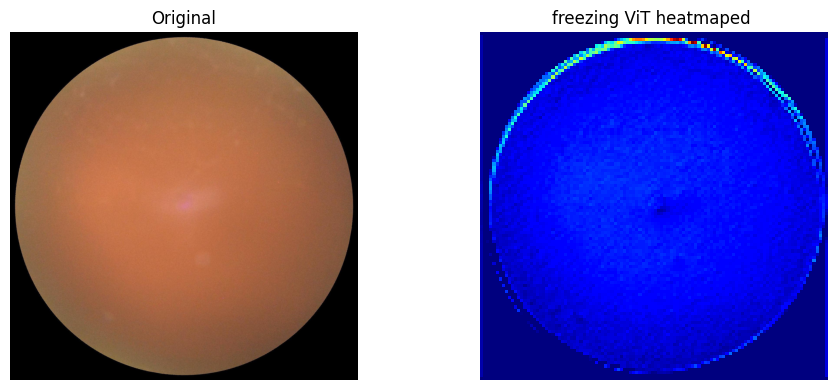

In [53]:
import torch
import torch.nn as nn
import torchvision.models as models
from torchvision import transforms
import cv2
from torchvision.models import ResNet
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
# Load the pre-trained RESNET18 model with CBAM attention mechanism
#model=resnet18_ccsam(num_classes=5)

# Remove the last fully connected layer
#model.fc = torch.nn.Identity()
#model.fc2 = torch.nn.Identity()
model = Freezing_layer_Resnet18WithCCSAM1(num_classes=5)

# Load the ResNet18 model
#model = models.resnet18(pretrained=True)
#model.eval()
# Load the pre-trained ResNet50 model
#model=Pre_ResNet18Model1(num_classes=5)
model.eval()

# Define the preprocessing transformations
preprocess = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Load and preprocess the image
#image_path = "E:/jupyter notebook/last_code_model/olii/AMD.jpg"
image_path = "E:/jupyter notebook/last_code_model/olii/CATARACT.jpg"
#image_path = "E:/jupyter notebook/last_code_model/olii/DR.jpg"
#image_path = "E:/jupyter notebook/last_code_model/olii/GLAUCOMA.jpg"
#image_path = "E:/jupyter notebook/last_code_model/olii/OTHER.jpg"
image = Image.open(image_path).convert('RGB')
# Preprocess the image

input_tensor = preprocess(image).unsqueeze(0)

# Forward pass through the model
output = model(input_tensor)
pred_label = torch.argmax(output, dim=1).item()

# Get the gradients with respect to the input tensor
model.zero_grad()
output[:, pred_label].backward()

# Get the gradients from the model's first convolutional layer
gradients = model.model.conv1.weight.grad

# Average the gradients across the RGB channels
pooled_gradients = torch.mean(gradients, dim=[2, 3])

# Get the feature maps from the last convolutional layer
features = model.model.conv1(input_tensor)


# Multiply the feature maps by the corresponding gradients
for i in range(features.size(0)):
    features[:, i, :, :] *= pooled_gradients[0, i]

# Sum the feature maps along the channels dimension
heatmap = torch.sum(features, dim=1).squeeze()

# Normalize the heat map values
heatmap = nn.functional.relu(heatmap)
heatmap /= torch.max(heatmap)

# Convert the heat map to a numpy array
heatmap = heatmap.detach().numpy()

# Visualize the heat map
#plt.imshow('Original Image', image)
#plt.imshow(heatmap, cmap='jet')
#plt.axis('off')
#plt.show()

# Apply the attention map to the original image
#heatmap = cv2.applyColorMap(attention_map, cv2.COLORMAP_JET)
# Superimpose the heat map on the original image

# Display the original image, attention map, and superimposed image
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
ax[0].imshow(image)
ax[0].set_title('Original')
ax[0].axis('off')

ax[1].imshow(heatmap, cmap='jet')
ax[1].set_title('freezing ViT heatmaped ')
ax[1].axis('off')


plt.tight_layout()
plt.show()



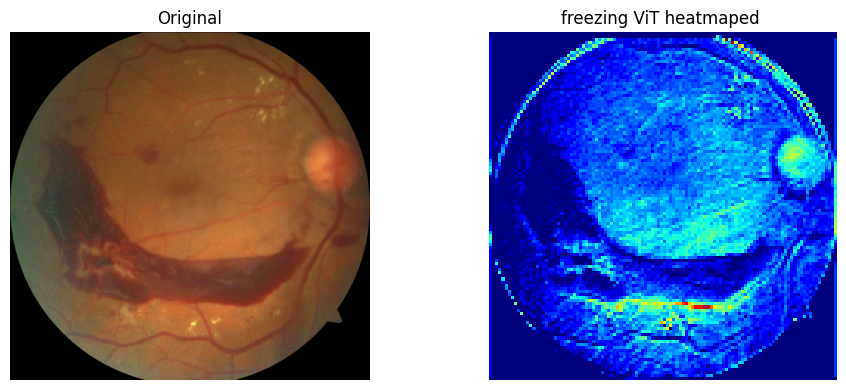

In [54]:
import torch
import torch.nn as nn
import torchvision.models as models
from torchvision import transforms
import cv2
from torchvision.models import ResNet
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
# Load the pre-trained RESNET18 model with CBAM attention mechanism
#model=resnet18_ccsam(num_classes=5)

# Remove the last fully connected layer
#model.fc = torch.nn.Identity()
#model.fc2 = torch.nn.Identity()
model = Freezing_layer_Resnet18WithCCSAM1(num_classes=5)

# Load the ResNet18 model
#model = models.resnet18(pretrained=True)
#model.eval()
# Load the pre-trained ResNet50 model
#model=Pre_ResNet18Model1(num_classes=5)
model.eval()

# Define the preprocessing transformations
preprocess = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Load and preprocess the image
#image_path = "E:/jupyter notebook/last_code_model/olii/AMD.jpg"
#image_path = "E:/jupyter notebook/last_code_model/olii/CATARACT.jpg"
image_path = "E:/jupyter notebook/last_code_model/olii/DR.jpg"
#image_path = "E:/jupyter notebook/last_code_model/olii/GLAUCOMA.jpg"
#image_path = "E:/jupyter notebook/last_code_model/olii/OTHER.jpg"
image = Image.open(image_path).convert('RGB')
# Preprocess the image

input_tensor = preprocess(image).unsqueeze(0)

# Forward pass through the model
output = model(input_tensor)
pred_label = torch.argmax(output, dim=1).item()

# Get the gradients with respect to the input tensor
model.zero_grad()
output[:, pred_label].backward()

# Get the gradients from the model's first convolutional layer
gradients = model.model.conv1.weight.grad

# Average the gradients across the RGB channels
pooled_gradients = torch.mean(gradients, dim=[2, 3])

# Get the feature maps from the last convolutional layer
features = model.model.conv1(input_tensor)


# Multiply the feature maps by the corresponding gradients
for i in range(features.size(0)):
    features[:, i, :, :] *= pooled_gradients[0, i]

# Sum the feature maps along the channels dimension
heatmap = torch.sum(features, dim=1).squeeze()

# Normalize the heat map values
heatmap = nn.functional.relu(heatmap)
heatmap /= torch.max(heatmap)

# Convert the heat map to a numpy array
heatmap = heatmap.detach().numpy()

# Visualize the heat map
#plt.imshow('Original Image', image)
#plt.imshow(heatmap, cmap='jet')
#plt.axis('off')
#plt.show()

# Apply the attention map to the original image
#heatmap = cv2.applyColorMap(attention_map, cv2.COLORMAP_JET)
# Superimpose the heat map on the original image

# Display the original image, attention map, and superimposed image
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
ax[0].imshow(image)
ax[0].set_title('Original')
ax[0].axis('off')

ax[1].imshow(heatmap, cmap='jet')
ax[1].set_title('freezing ViT heatmaped ')
ax[1].axis('off')


plt.tight_layout()
plt.show()



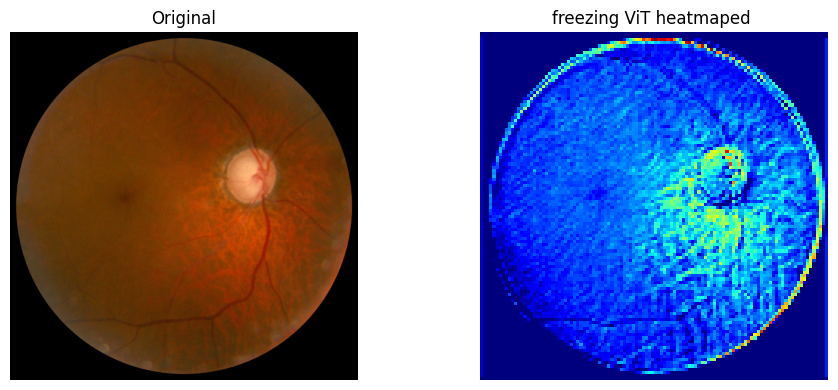

In [55]:
import torch
import torch.nn as nn
import torchvision.models as models
from torchvision import transforms
import cv2
from torchvision.models import ResNet
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
# Load the pre-trained RESNET18 model with CBAM attention mechanism
#model=resnet18_ccsam(num_classes=5)

# Remove the last fully connected layer
#model.fc = torch.nn.Identity()
#model.fc2 = torch.nn.Identity()
model = Freezing_layer_Resnet18WithCCSAM1(num_classes=5)

# Load the ResNet18 model
#model = models.resnet18(pretrained=True)
#model.eval()
# Load the pre-trained ResNet50 model
#model=Pre_ResNet18Model1(num_classes=5)
model.eval()

# Define the preprocessing transformations
preprocess = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Load and preprocess the image
#image_path = "E:/jupyter notebook/last_code_model/olii/AMD.jpg"
#image_path = "E:/jupyter notebook/last_code_model/olii/CATARACT.jpg"
#image_path = "E:/jupyter notebook/last_code_model/olii/DR.jpg"
image_path = "E:/jupyter notebook/last_code_model/olii/GLAUCOMA.jpg"
#image_path = "E:/jupyter notebook/last_code_model/olii/OTHER.jpg"
image = Image.open(image_path).convert('RGB')
# Preprocess the image

input_tensor = preprocess(image).unsqueeze(0)

# Forward pass through the model
output = model(input_tensor)
pred_label = torch.argmax(output, dim=1).item()

# Get the gradients with respect to the input tensor
model.zero_grad()
output[:, pred_label].backward()

# Get the gradients from the model's first convolutional layer
gradients = model.model.conv1.weight.grad

# Average the gradients across the RGB channels
pooled_gradients = torch.mean(gradients, dim=[2, 3])

# Get the feature maps from the last convolutional layer
features = model.model.conv1(input_tensor)


# Multiply the feature maps by the corresponding gradients
for i in range(features.size(0)):
    features[:, i, :, :] *= pooled_gradients[0, i]

# Sum the feature maps along the channels dimension
heatmap = torch.sum(features, dim=1).squeeze()

# Normalize the heat map values
heatmap = nn.functional.relu(heatmap)
heatmap /= torch.max(heatmap)

# Convert the heat map to a numpy array
heatmap = heatmap.detach().numpy()

# Visualize the heat map
#plt.imshow('Original Image', image)
#plt.imshow(heatmap, cmap='jet')
#plt.axis('off')
#plt.show()

# Apply the attention map to the original image
#heatmap = cv2.applyColorMap(attention_map, cv2.COLORMAP_JET)
# Superimpose the heat map on the original image

# Display the original image, attention map, and superimposed image
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
ax[0].imshow(image)
ax[0].set_title('Original')
ax[0].axis('off')

ax[1].imshow(heatmap, cmap='jet')
ax[1].set_title('freezing ViT heatmaped ')
ax[1].axis('off')


plt.tight_layout()
plt.show()



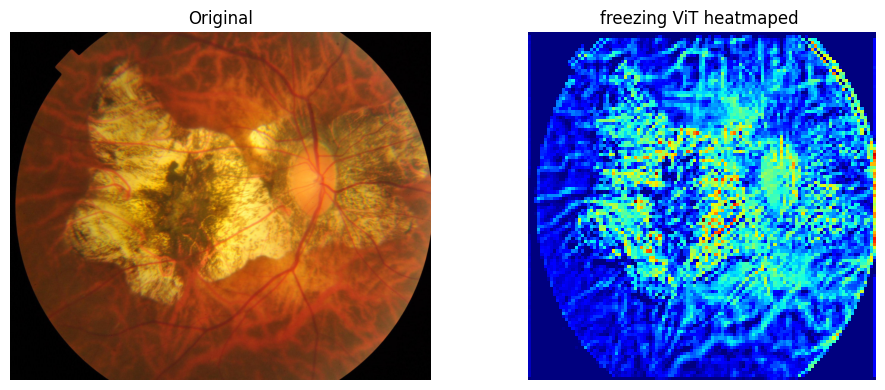

In [57]:
import torch
import torch.nn as nn
import torchvision.models as models
from torchvision import transforms
import cv2
from torchvision.models import ResNet
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
# Load the pre-trained RESNET18 model with CBAM attention mechanism
#model=resnet18_ccsam(num_classes=5)

# Remove the last fully connected layer
#model.fc = torch.nn.Identity()
#model.fc2 = torch.nn.Identity()
model = Freezing_layer_Resnet18WithCCSAM1(num_classes=5)

# Load the ResNet18 model
#model = models.resnet18(pretrained=True)
#model.eval()
# Load the pre-trained ResNet50 model
#model=Pre_ResNet18Model1(num_classes=5)
model.eval()

# Define the preprocessing transformations
preprocess = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Load and preprocess the image
#image_path = "E:/jupyter notebook/last_code_model/olii/AMD.jpg"
#image_path = "E:/jupyter notebook/last_code_model/olii/CATARACT.jpg"
#image_path = "E:/jupyter notebook/last_code_model/olii/DR.jpg"
#image_path = "E:/jupyter notebook/last_code_model/olii/GLAUCOMA.jpg"
image_path = "E:/jupyter notebook/last_code_model/olii/OTHER.jpg"
image = Image.open(image_path).convert('RGB')
# Preprocess the image

input_tensor = preprocess(image).unsqueeze(0)

# Forward pass through the model
output = model(input_tensor)
pred_label = torch.argmax(output, dim=1).item()

# Get the gradients with respect to the input tensor
model.zero_grad()
output[:, pred_label].backward()

# Get the gradients from the model's first convolutional layer
gradients = model.model.conv1.weight.grad

# Average the gradients across the RGB channels
pooled_gradients = torch.mean(gradients, dim=[2, 3])

# Get the feature maps from the last convolutional layer
features = model.model.conv1(input_tensor)


# Multiply the feature maps by the corresponding gradients
for i in range(features.size(0)):
    features[:, i, :, :] *= pooled_gradients[0, i]

# Sum the feature maps along the channels dimension
heatmap = torch.sum(features, dim=1).squeeze()

# Normalize the heat map values
heatmap = nn.functional.relu(heatmap)
heatmap /= torch.max(heatmap)

# Convert the heat map to a numpy array
heatmap = heatmap.detach().numpy()

# Visualize the heat map
#plt.imshow('Original Image', image)
#plt.imshow(heatmap, cmap='jet')
#plt.axis('off')
#plt.show()

# Apply the attention map to the original image
#heatmap = cv2.applyColorMap(attention_map, cv2.COLORMAP_JET)
# Superimpose the heat map on the original image

# Display the original image, attention map, and superimposed image
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
ax[0].imshow(image)
ax[0].set_title('Original')
ax[0].axis('off')

ax[1].imshow(heatmap, cmap='jet')
ax[1].set_title('freezing ViT heatmaped ')
ax[1].axis('off')


plt.tight_layout()
plt.show()



In [74]:
from PIL import Image
import math

# List of input image paths
image_paths = [
    "E:/jupyter notebook/last_code_model/olii/heat map/image1.JPG",
    "E:/jupyter notebook/last_code_model/olii/heat map/image2.JPG",
    "E:/jupyter notebook/last_code_model/olii/heat map/image3.JPG",
    "E:/jupyter notebook/last_code_model/olii/heat map/image4.JPG",
    "E:/jupyter notebook/last_code_model/olii/heat map/image5.JPG",
    "E:/jupyter notebook/last_code_model/olii/heat map/image6.JPG",
    "E:/jupyter notebook/last_code_model/olii/heat map/image7.JPG",
    "E:/jupyter notebook/last_code_model/olii/heat map/image8.JPG",
    "E:/jupyter notebook/last_code_model/olii/heat map/image9.JPG",
    "E:/jupyter notebook/last_code_model/olii/heat map/image10.JPG",
    "E:/jupyter notebook/last_code_model/olii/heat map/image11.JPG",
    "E:/jupyter notebook/last_code_model/olii/heat map/image12.JPG",
    "E:/jupyter notebook/last_code_model/olii/heat map/image13.JPG",
    "E:/jupyter notebook/last_code_model/olii/heat map/image14.JPG",
    "E:/jupyter notebook/last_code_model/olii/heat map/image15.JPG",
    
    # Add the paths of the remaining 18 images here
]

# Desired width and height for the images in the collage
target_width = 300
target_height = 300

# Calculate the number of rows and columns for the collage
num_rows = 5
num_cols = 3

# Create a blank canvas for the collage
collage_width = target_width * num_cols
collage_height = target_height * num_rows
collage = Image.new("RGB", (collage_width, collage_height))

# Iterate over the image paths and resize each image
for i, image_path in enumerate(image_paths):
    # Open the image
    image = Image.open(image_path)

    # Resize the image
    image = image.resize((target_width, target_height))

    # Calculate the coordinates for placing the resized image in the collage
    row = math.floor(i / num_cols)
    col = i % num_cols
    x = col * target_width
    y = row * target_height

    # Paste the resized image onto the collage
    collage.paste(image, (x, y))

# Display the collage
collage.show()
